# 数据处理

在工业实践中，由于面临的任务和数据环境千差万别，通常需要编写适合当前任务的数据处理程序，一般涉及五个环节：
1. 读入数据
2. 划分数据集
3. 生成批次数据
4. 训练样本集乱序
5. 校验数据有效性

In [1]:
# 加载飞浆及相关的库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F

import numpy as np
import os
import gzip
import json
import random

## 读入数据并划分数据集

在实际应用中，数据集通常包含训练样本、验证样本及测试样本三个部分，每个样本都包含特征和标签。
- 训练集：用于确定模型参数
- 验证集：用于调节模型超参数（如多个网络结构、正则化权重的最优选择）
- 测试集：用于估计模型效果（没有在模型中应用过的数据，更贴近模型在真实场景应用的效果）

在本手写数字MNIST数据的训练集中，包含两个元素的列表：
- train_images: [50000, 784]的二维列表，包含50000张图片，每张图片用一个长度为784的向量表示，内容是28x28尺寸的像素灰度值（黑白照片）
- train_labels: [50000, ]的列表，表示这些图片对应的分类标签，即0 - 9之间的一个数字

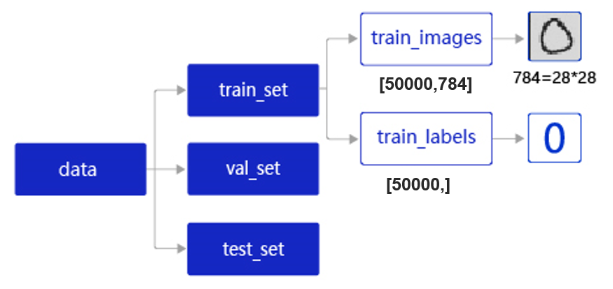

- 当几个模型的准确率在测试集上差距不大时，应尽量选择网络结构相对简单的模型。
- 往往设计越精巧的模型，越不容易在不同的数据集之间迁移。

In [5]:
# 声明数据集文件位置
datafile = r'../datasets/mnist.json.gz'
print('Loading mnist dataset from {} ...'.format(datafile))

# 加载json数据文件
data = json.load(gzip.open(datafile))
print('MNIST dataset load done')

# 划分训练接、验证集、测试集
train_set, val_set, test_set = data

# 训练数据集
imgs, labels = train_set[0], train_set[1]
print('训练数据集数量：', len(imgs))

# 验证数据集
imgs, labels = val_set[0], val_set[1]
print('验证数据集数量：', len(imgs))

# 测试数据集
imgs, labels = val_set[0], val_set[1]
print('测试数据集数量：', len(imgs))

Loading mnist dataset from ../datasets/mnist.json.gz ...
MNIST dataset load done
训练数据集数量： 50000
验证数据集数量： 10000
测试数据集数量： 10000


## 训练样本乱序，生成批次数据

- 训练样本乱序：模型对最后出现的数据印象更加深刻，为了避免模型记忆影响模型效果，需要对样本进行乱序操作。
- 生成批次数据：先设置合理的batch_size,再将数据转变成符合模型输入要求的np.array格式。

In [6]:
# 获取训练数据集
train_imgs, train_labels = train_set[0], train_set[1]

# 获取训练数据集长度
imgs_length = len(train_imgs)

# 定义训练数据集每项数据的序号，根据序号读取数据
index_list = list(range(imgs_length))

# 随机打乱训练数据的索引序号
random.shuffle(index_list)

# 读入数据时用到的批次大小
BATCHSIZE = 100

# 定义数据生成器，返回批次数据
def data_generator():
    imgs_list = []
    labels_list = []
    for i in index_list:
        # 将数据转换成需要的类型
        img = np.array(train_imgs[i]).astype('float32')
        label = np.array(train_labels[i]).astype('float32')
        # 把当前数据加入列表
        imgs_list.append(img)
        labels_list.append(label)
        if len(imgs_list) == BATCHSIZE:
            # 获得一个批次的数据并返回
            # 将生成器设置为yield模式，以减少内存占用
            yield np.array(imgs_list), np.array(labels_list)
            # 清空数据列表
            imgs_list = []
            labels_list = []
            
    # 如果最后剩余的数据长度小于BATCHSIZE，则自动构成一个批次
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
        
    return data_generator

In [7]:
# 声明数据读取函数，从训练集中读取数据
train_loader = data_generator

# 以迭代的形式读取数据
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    
    # 打印第一条数据的形状和类型
    if batch_id == 0:
        print('第一个批次数据的图像维度：{}，标签维度：{}'.format(image_data.shape, label_data.shape))
        
    break

第一个批次数据的图像维度：(100, 784)，标签维度：(100,)


## 数据校验

- 机器校验：加入一些校验和清理数据的操作。
- 人工校验：先打印数据输出结果，观察是否是设置的格式，然后再从训练的结果验证数据处理和读取的有效性。

In [10]:
# 封装数据读取与处理函数
def load_data(mode='train'):
    # 声明数据集文件位置
    datafile = r'../datasets/mnist.json.gz'
    print('Loading mnist dataset from {} ...'.format(datafile))

    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('MNIST dataset load done')
    
    # 划分训练集、验证集、测试集
    train_set, val_set, test_set = data
    if mode=='train':
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        imgs, labels = val_set[0], val_set[1]
    elif mode=='test':
        imgs, labels = test_set[0], test_set[1]
    else:
        raise Exception("Mode can only be one of ['train', 'valid', 'test']")
    print('数据集长度：', len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)
    
    assert len(imgs) == len(labels), \
        "Length of imgs({}) should be the same as labels({})".format(len(imgs), len(labels))
        
    # 定义训练数据集每项数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))

    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    
    # 定义数据生成器，返回批次数据
    def data_generator():
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据转换成需要的类型
            img = np.array(train_imgs[i]).astype('float32')
            label = np.array(train_labels[i]).astype('float32')
            # 把当前数据加入列表
            imgs_list.append(img)
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个批次的数据并返回
                # 将生成器设置为yield模式，以减少内存占用
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据列表
                imgs_list = []
                labels_list = []

        # 如果最后剩余的数据长度小于BATCHSIZE，则自动构成一个批次
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

In [11]:
# 测试
load_data()

Loading mnist dataset from ../datasets/mnist.json.gz ...
MNIST dataset load done
数据集长度： 50000


<function __main__.load_data.<locals>.data_generator()>

In [12]:
# 定义一层网络结构，利用定义好的数据处理函数，完成神经网络的训练
class MNIST(paddle.nn.Layer):
    # 初始化
    def __init__(self):
        # 调用父类初始化方法
        super(MNIST, self).__init__()
        # 定义一层全连接层，输出维度是1
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)
        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [15]:
# 定义训练方法
def train(model):
    # 启动训练模式
    model.train()
    # 加载训练数据集
    train_loader = load_data('train')
    # 定义优化算法，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    
    # 定义外层循环次数
    EPOCH_NUM = 10
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            # 准备训练数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            # 前向计算的过程
            predicts = model(images)
            
            # 计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            # 每训练200批次的数据，打印当前Loss情况
            if batch_id % 200 == 0:
                print('epoch_id: {}, batch_id: {}, loss is {}'.format(epoch, batch_id, avg_loss.numpy()))
                
            # 反向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
    # 保存模型参数
    paddle.save(model.state_dict(), '../models/mnist.pdparams')

In [16]:
# 创建模型
model = MNIST()

# 启动训练
train(model)

Loading mnist dataset from ../datasets/mnist.json.gz ...
MNIST dataset load done
数据集长度： 50000
epoch_id: 0, batch_id: 0, loss is [33.1279]
epoch_id: 0, batch_id: 200, loss is [8.209873]
epoch_id: 0, batch_id: 400, loss is [8.904402]
epoch_id: 1, batch_id: 0, loss is [9.140996]
epoch_id: 1, batch_id: 200, loss is [8.144614]
epoch_id: 1, batch_id: 400, loss is [8.875295]
epoch_id: 2, batch_id: 0, loss is [9.106609]
epoch_id: 2, batch_id: 200, loss is [8.125147]
epoch_id: 2, batch_id: 400, loss is [8.868296]
epoch_id: 3, batch_id: 0, loss is [9.092506]
epoch_id: 3, batch_id: 200, loss is [8.113581]
epoch_id: 3, batch_id: 400, loss is [8.8655815]
epoch_id: 4, batch_id: 0, loss is [9.08424]
epoch_id: 4, batch_id: 200, loss is [8.105441]
epoch_id: 4, batch_id: 400, loss is [8.864111]
epoch_id: 5, batch_id: 0, loss is [9.0786085]
epoch_id: 5, batch_id: 200, loss is [8.099353]
epoch_id: 5, batch_id: 400, loss is [8.863134]
epoch_id: 6, batch_id: 0, loss is [9.07443]
epoch_id: 6, batch_id: 200, 